# Evaluation by MRI characteristics

In [20]:

import os
import sys
import argparse
import traceback


import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from itertools import combinations, permutations

import cmbnet.utils.utils_plotting as utils_plotting
import cmbnet.utils.utils_evaluation as utils_eval
import ast


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)


In [21]:
eval_dir = "../../data-misc/evaluations"

l1_dirs = ["Scratch-Pretrained-FineTuned"]  # winner
l2_dirs = ["predict_cmb_valid", "predict_cmb_dou", "predict_cmb_crb"]
l3_dirs = ["valloss"]

(
    df_classification,
    df_detection,
    df_segmentation,
    detection_details,
    segmentation_details,
    cmb_results,
) = utils_eval.load_evaluation_data(
    eval_dir, l1_dirs, l2_dirs, l3_dirs
)

In [22]:
# Flatten the data into a list
flattened_data = []
for key, entries in detection_details.items():
    if not entries:
        continue
    for entry in entries:
        # Combine key tuple and entry dictionary
        combined_entry = dict(zip(['Model', 'Dataset', 'Criteria', 'Location'], key))
        combined_entry.update(entry)
        flattened_data.append(combined_entry)

# Create a DataFrame
df_detection_serieslevel = pd.DataFrame(flattened_data)


In [23]:
gt_radiomics_metadata_csv = (
    "../../data-misc/csv/CMB_radiomics_metadata.csv"
)
gt_cmb_metadata_csv = (
    "../..//data-misc/csv/CMB_metadata_all.csv"
)
all_studies_csv = "../../data-misc/csv/ALL_studies.csv"

all_studies_df = pd.read_csv(all_studies_csv)
valid_studies  =os.listdir("/storage/evo1/jorge/datasets/cmb/cmb_valid/Data")
all_studies_testing = all_studies_df[(all_studies_df["seriesUID"].isin(valid_studies)) | (all_studies_df["Dataset"].isin(['DOU', 'CRB']))]

GT_metadata = pd.read_csv(gt_cmb_metadata_csv)
GT_metadata_radiomics = pd.read_csv(gt_radiomics_metadata_csv)

# Convert string representations of tuples to actual tuples
GT_metadata["CM"] = GT_metadata["CM"].apply(lambda x: tuple(ast.literal_eval(x)))
GT_metadata_radiomics["CM"] = GT_metadata_radiomics["CM"].apply(
    lambda x: tuple(ast.literal_eval(x))
)

GT_metadata_all = pd.merge(
    GT_metadata, GT_metadata_radiomics, on=["seriesUID", "CM"], how="inner"
).drop(
    columns=[
        "firstorder_10Percentile",
        "firstorder_90Percentile",
        "firstorder_Energy",
        "firstorder_Entropy",
        "firstorder_InterquartileRange",
        "firstorder_Kurtosis",
        "firstorder_Maximum",
        "firstorder_MeanAbsoluteDeviation",
        "firstorder_Mean",
        "firstorder_Median",
        "firstorder_Minimum",
        "firstorder_Range",
        "firstorder_RobustMeanAbsoluteDeviation",
        "firstorder_RootMeanSquared",
        "firstorder_Skewness",
        "firstorder_TotalEnergy",
        "firstorder_Uniformity",
        "firstorder_Variance",
    ]
)


/tmp/ipykernel_3252832/3555144406.py:13: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  GT_metadata = pd.read_csv(gt_cmb_metadata_csv)


# Undestand data better

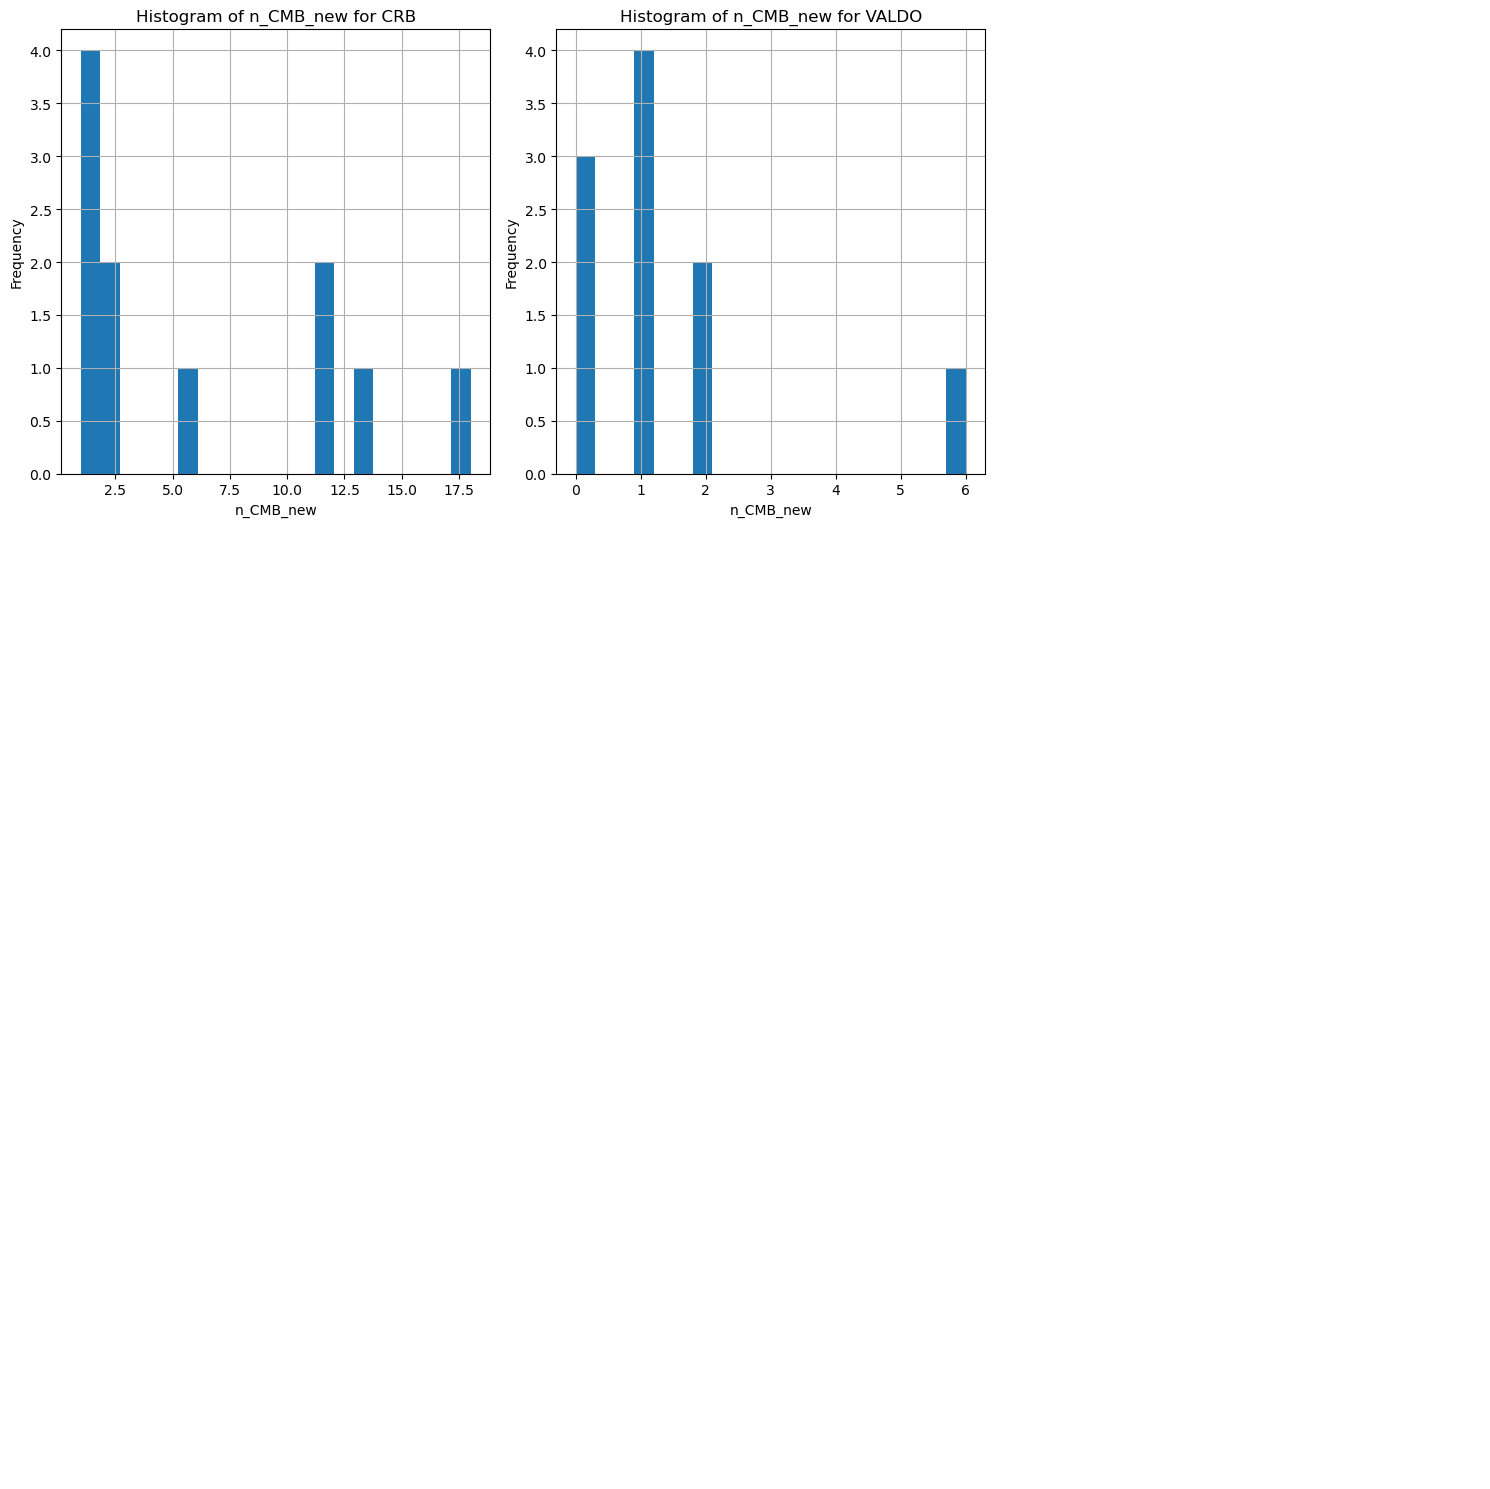

In [24]:
import matplotlib.pyplot as plt

# Filter the DataFrame
filtered_data = all_studies_testing[all_studies_testing['seq_type']=="T2S"]

# Get unique datasets
unique_datasets = filtered_data['Dataset'].unique()

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjust size as needed
axs = axs.flatten()  # Flatten the 2D array of axes to simplify the loop

# Loop through the datasets and plot histograms in each subplot
for i, dataset in enumerate(unique_datasets):
    ax = axs[i]  # Select the corresponding subplot
    data_subset = filtered_data[filtered_data['Dataset'] == dataset]
    data_subset['n_CMB_new'].hist(bins=20, ax=ax)
    ax.set_title(f'Histogram of n_CMB_new for {dataset}')
    ax.set_xlabel('n_CMB_new')
    ax.set_ylabel('Frequency')

# If there are more subplots than datasets, turn off the extra subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


# Re-computed macro and micro

In [25]:
print(
    df_detection_serieslevel["Model"].unique(),
    df_detection_serieslevel["Criteria"].unique(),
)
print(
    df_detection_serieslevel.columns
)

['Scratch-Pretrained-FineTuned'] ['valloss']
Index(['Model', 'Dataset', 'Criteria', 'seriesUID', 'Precision', 'Recall',
       'F1', 'FPavg', 'FPcmb', 'TP', 'FP', 'FN', 'n_true_cmb', 'n_pred_cmb'],
      dtype='object')


In [26]:
aggregations = {
    'Precision': ['mean', 'std', 'count'],
    'Recall': ['mean', 'std', 'count'],
    'F1': ['mean', 'std', 'count'],
    'FPavg': ['mean', 'std', 'count'],
    'FPcmb': ['mean', 'std', 'count'],
    'TP': ['sum', 'mean'],
    'FP': ['sum', 'mean'],
    'FN': ['sum', 'mean'],
    'n_true_cmb': ['sum'],
    'n_pred_cmb': ['sum'],
}

## Number of microbleeds per scan

In [27]:
all_studies_df.columns

Index(['seriesUID', 'series', 'n_CMB_new', 'seq_type', 'res_level', 'healthy',
       'healthy_all', 'field_strength', 'TE', 'subject', 'patientUID',
       'Dataset', 'n_CMB_old', 'old_shape', 'new_shape', 'old_voxel_dim',
       'new_voxel_dim', 'old_orientation', 'new_orientation', 'studyUID_old',
       'n_indataset', 'newCMB', 'diffCMB', 'nCMB_avg', 'CMB_level'],
      dtype='object')

In [28]:
# lft join all study df
df_detection_serieslevel  = pd.merge(df_detection_serieslevel, all_studies_testing[['seriesUID', 'seq_type', "CMB_level"]], on="seriesUID", how="left")

In [48]:
filtered_data = all_studies_testing

studies_normal_count = filtered_data['seriesUID']

# Macro
df_detection_serieslevel_normalcount = df_detection_serieslevel[df_detection_serieslevel['seriesUID'].isin(studies_normal_count)]
print(
    f"Filtered data from {len(df_detection_serieslevel)} to {len(df_detection_serieslevel_normalcount)}"
)
df_detection_serieslevel_macro = df_detection_serieslevel_normalcount.groupby(['Dataset', 'seq_type', 'CMB_level']).agg(aggregations).round(2)


# Micro
global_cm = df_detection_serieslevel_normalcount.groupby(['Dataset', 'seq_type', 'CMB_level']).agg(
 {
    'TP': ['sum'],
    'FP': ['sum'],
    'FN': ['sum'],
    'seriesUID': ['count'],
}   
    
    ).round(2)

global_cm.reset_index(inplace=True)
global_cm.columns = global_cm.columns.droplevel(1)
df_detection_serieslevel_micro = global_cm.copy()
df_detection_serieslevel_micro['Precision'] = df_detection_serieslevel_micro['TP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FP'])
df_detection_serieslevel_micro['Recall'] = df_detection_serieslevel_micro['TP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['F1'] = 2 * (df_detection_serieslevel_micro['Precision'] * df_detection_serieslevel_micro['Recall']) / (df_detection_serieslevel_micro['Precision'] + df_detection_serieslevel_micro['Recall'])
df_detection_serieslevel_micro['FPavg'] = df_detection_serieslevel_micro['FP'] / df_detection_serieslevel_micro['seriesUID']
df_detection_serieslevel_micro['FPcmb'] = df_detection_serieslevel_micro['FP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['FNavg'] = df_detection_serieslevel_micro['FN'] / df_detection_serieslevel_micro['seriesUID']
df_detection_serieslevel_micro['FNcmb'] = df_detection_serieslevel_micro['FN'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])


df_detection_serieslevel_micro = df_detection_serieslevel_micro[df_detection_serieslevel_micro['Dataset'] != "dou"].round(3)
df_detection_serieslevel_micro


Filtered data from 78 to 78


,Dataset,seq_type,CMB_level,TP,FP,FN,seriesUID,Precision,Recall,F1,FPavg,FPcmb,FNavg,FNcmb
0,crb,SWI,high,24,7,29,5,0.774,0.453,0.571,1.400,0.132,5.800,0.547
1,crb,SWI,low,1,0,4,2,1.000,0.200,0.333,0.000,0.000,2.000,0.800
2,crb,T2S,high,9,3,52,5,0.750,0.148,0.247,0.600,0.049,10.400,0.852
3,crb,T2S,low,4,6,4,6,0.400,0.500,0.444,1.000,0.750,0.667,0.500
6,valid,SWI,high,44,23,19,5,0.657,0.698,0.677,4.600,0.365,3.800,0.302
7,valid,SWI,low,14,15,6,19,0.483,0.700,0.571,0.789,0.750,0.316,0.300
8,valid,T2S,high,6,1,0,1,0.857,1.000,0.923,1.000,0.167,0.000,0.000
9,valid,T2S,low,7,1,1,6,0.875,0.875,0.875,0.167,0.125,0.167,0.125


In [45]:
print(df_detection_serieslevel_micro.to_latex(index=False, escape=False))

\begin{tabular}{lllrrrrrrr}
\toprule
Dataset & seq_type & CMB_level & TP & FP & FN & seriesUID & Precision & Recall & F1 \\
\midrule
crb & SWI & high & 24 & 7 & 29 & 5 & 0.774000 & 0.453000 & 0.571000 \\
crb & SWI & low & 1 & 0 & 4 & 2 & 1.000000 & 0.200000 & 0.333000 \\
crb & T2S & high & 9 & 3 & 52 & 5 & 0.750000 & 0.148000 & 0.247000 \\
crb & T2S & low & 4 & 6 & 4 & 6 & 0.400000 & 0.500000 & 0.444000 \\
valid & SWI & high & 44 & 23 & 19 & 5 & 0.657000 & 0.698000 & 0.677000 \\
valid & SWI & low & 14 & 15 & 6 & 19 & 0.483000 & 0.700000 & 0.571000 \\
valid & T2S & high & 6 & 1 & 0 & 1 & 0.857000 & 1.000000 & 0.923000 \\
valid & T2S & low & 7 & 1 & 1 & 6 & 0.875000 & 0.875000 & 0.875000 \\
\bottomrule
\end{tabular}



In [42]:
df_detection_serieslevel_macro

Precision             Recall                F1              \
                      mean   std count   mean   std count  mean   std count   
Dataset seq_type                                                              
crb     SWI           0.90  0.17     6   0.34  0.26     7  0.50  0.19     6   
        T2S           0.70  0.27     9   0.34  0.37    11  0.38  0.19     9   
dou     SWI           0.91  0.19    18   0.79  0.34    20  0.87  0.19    18   
valid   SWI           0.43  0.44    31   0.77  0.33    19  0.77  0.21    17   
        T2S           0.79  0.37     8   0.93  0.19     7  0.89  0.16     7   

                 FPavg             FPcmb              TP        FP        FN  \
                  mean   std count  mean   std count sum  mean sum  mean sum   
Dataset seq_type                                                               
crb     SWI       1.00  1.91     7  0.10  0.19     7  25  3.57   7  1.00  33   
        T2S       0.82  1.17    11  0.52  1.20    11  13  1.18   9  0.82  56   
dou     SWI       0.50  1.24    20  0.15  0.46    20  51  2.55  10  0.50  23   
valid   SWI       2.03  3.04    32  0.53  0.83    19  58  1.81  65  2.03  25   
        T2S       0.38  0.52     8  0.17  0.37     7  13  1.62   3  0.38   1   

                       n_true_cmb n_pred_cmb  
                  mean        sum        sum  
Dataset seq_type                              
crb     SWI       4.71         58         32  
        T2S       5.09         69         23  
dou     SWI       1.15         74         62  
valid   SWI       0.78         83        123  
        T2S       0.12         14         16

In [32]:
tmp_stud = all_studies_testing[(all_studies_testing['Dataset'] == "CRB") & (all_studies_testing['seq_type'] == "SWI") ]['seriesUID']
df_detection_serieslevel[df_detection_serieslevel['seriesUID'].isin(tmp_stud)]

,Model,Dataset,Criteria,seriesUID,Precision,Recall,F1,FPavg,FPcmb,TP,FP,FN,n_true_cmb,n_pred_cmb,seq_type,CMB_level
69,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.2.840.113845.11.1000000001815528930.20201010223701.3603014-CMB-4,0.600000,0.750000,0.666667,2.0,0.500000,3,2,1,4,5,SWI,high
70,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.2.840.113845.13.13849.872975378.634767293118-CMB-29,0.772727,0.586207,0.666667,5.0,0.172414,17,5,12,29,22,SWI,high
71,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.2.840.113845.13.14537.872975378.3343495815236-CMB-3,1.000000,0.333333,0.500000,0.0,0.000000,1,0,2,3,1,SWI,low
72,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082104124198400000043-CMB-4,1.000000,0.250000,0.400000,0.0,0.000000,1,0,3,4,1,SWI,high
73,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082104124198400000049-CMB-2,NaN,0.000000,NaN,0.0,0.000000,0,0,2,2,0,SWI,low
74,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000001-CMB-5,1.000000,0.400000,0.571429,0.0,0.000000,2,0,3,5,2,SWI,high
75,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000040-CMB-11,1.000000,0.090909,0.166667,0.0,0.000000,1,0,10,11,1,SWI,high


In [33]:
all_studies_testing[(all_studies_testing['Dataset'].isin(["RODEJA", 'VALDO', 'MOMENI'])) & (all_studies_testing['seq_type'] == "T2S")]


,seriesUID,series,n_CMB_new,seq_type,res_level,healthy,healthy_all,field_strength,TE,subject,patientUID,Dataset,n_CMB_old,old_shape,new_shape,old_voxel_dim,new_voxel_dim,old_orientation,new_orientation,studyUID_old,n_indataset,newCMB,diffCMB,nCMB_avg,CMB_level
673,VALDO-103-CMB-6,103-CMB,6,T2S,high,no,False,1.5/3,25.0,sub-103,103val,VALDO,6,"[512, 512, 35]","[298, 381, 291]","[0.4492187201976776, 0.4492187798023224, 4.0]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-103,3,False,False,6.0,high
674,VALDO-104-H,104-H,0,T2S,high,yes,True,1.5/3,25.0,sub-104,104val,VALDO,0,"[512, 512, 35]","[323, 366, 349]","[0.4492187201976776, 0.44921875, 4.0]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-104,4,False,False,0.0,NaN
1779,VALDO-205-H,205-H,0,T2S,high,yes,True,1.5/3,25.0,sub-205,205val,VALDO,0,"[512, 512, 192]","[287, 331, 283]","[0.4882810115814209, 0.4882810115814209, 0.800000011920929]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-205,16,False,False,0.0,NaN
1780,VALDO-206-H,206-H,0,T2S,high,yes,True,1.5/3,25.0,sub-206,206val,VALDO,0,"[512, 512, 192]","[259, 312, 280]","[0.4882810115814209, 0.4882810115814209, 0.800000011920929]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-206,17,False,False,0.0,NaN
1848,VALDO-208-CMB-1,208-CMB,1,T2S,high,no,False,1.5/3,25.0,sub-208,208val,VALDO,1,"[512, 512, 192]","[265, 334, 275]","[0.4882810115814209, 0.4882810115814209, 0.800000011920929]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-208,19,False,False,1.0,low
2738,VALDO-232-CMB-1,232-CMB,1,T2S,high,no,False,1.5/3,25.0,sub-232,232val,VALDO,1,"[512, 512, 192]","[270, 315, 270]","[0.4882810115814209, 0.4882810115814209, 0.800000011920929]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-232,43,False,False,1.0,low
4698,VALDO-302-CMB-1,302-CMB,1,T2S,low,no,False,1.5/3,25.0,sub-302,302val,VALDO,1,"[256, 256, 39]","[287, 351, 237]","[1.0, 1.0, 3.0000433921813965]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-302,47,False,False,1.0,low
4734,VALDO-305-CMB-2,305-CMB,2,T2S,low,no,False,1.5/3,25.0,sub-305,305val,VALDO,2,"[256, 256, 39]","[292, 368, 247]","[1.0, 1.0, 3.0000741481781006]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-305,50,False,False,2.0,low
4818,VALDO-320-CMB-2,320-CMB,2,T2S,low,no,False,1.5/3,25.0,sub-320,320val,VALDO,2,"[256, 256, 39]","[273, 326, 214]","[1.0, 1.0, 2.99997615814209]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-320,65,False,False,2.0,low
4822,VALDO-324-CMB-1,324-CMB,1,T2S,low,no,False,1.5/3,25.0,sub-324,324val,VALDO,1,"[256, 256, 39]","[283, 366, 239]","[1.0, 1.0, 3.000016927719116]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-324,69,False,False,1.0,low


In [34]:
df_detection_serieslevel[df_detection_serieslevel['CMB_level'] == "high"]

,Model,Dataset,Criteria,seriesUID,Precision,Recall,F1,FPavg,FPcmb,TP,FP,FN,n_true_cmb,n_pred_cmb,seq_type,CMB_level
3,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00070-CMB-10,0.888889,0.800000,0.842105,1.0,0.100000,8,1,2,10,9,SWI,high
5,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00100-CMB-9,0.388889,0.777778,0.518519,11.0,1.222222,7,11,2,9,18,SWI,high
8,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00116-CMB-11,1.000000,0.636364,0.777778,0.0,0.000000,7,0,4,11,7,SWI,high
12,Scratch-Pretrained-FineTuned,valid,valloss,VALDO-103-CMB-6,0.857143,1.000000,0.923077,1.0,0.166667,6,1,0,6,7,T2S,high
35,Scratch-Pretrained-FineTuned,valid,valloss,MOMENI-305_T0-CMB-16,0.750000,0.750000,0.750000,4.0,0.250000,12,4,4,16,16,SWI,high
36,Scratch-Pretrained-FineTuned,valid,valloss,MOMENI-305_T1-CMB-17,0.588235,0.588235,0.588235,7.0,0.411765,10,7,7,17,17,SWI,high
42,Scratch-Pretrained-FineTuned,dou,valloss,DOU-03-CMB-4,1.000000,1.000000,1.000000,0.0,0.000000,4,0,0,4,4,SWI,high
48,Scratch-Pretrained-FineTuned,dou,valloss,DOU-09-CMB-11,1.000000,0.363636,0.533333,0.0,0.000000,4,0,7,11,4,SWI,high
49,Scratch-Pretrained-FineTuned,dou,valloss,DOU-10-CMB-8,1.000000,0.750000,0.857143,0.0,0.000000,6,0,2,8,6,SWI,high
54,Scratch-Pretrained-FineTuned,dou,valloss,DOU-15-CMB-13,0.642857,0.692308,0.666667,5.0,0.384615,9,5,4,13,14,SWI,high
